In [33]:
import os, subprocess
import json
import uproot
import awkward as ak
import numpy as np
from coffea import processor, util, hist

%matplotlib inline
import matplotlib.pyplot as plt
from cycler import cycler

In [34]:
colors = {}
colors['QCD'] = '#1f77b4'
colors['VBF'] = '#ff7f0e'
colors['VV'] = '#2ca02c'
colors['Wjets'] = '#d62728'
colors['WH'] = '#9467bd'
colors['Zjets'] = '#8c564b'
colors['ZH'] = '#e377c2'
colors['ggF'] = '#7f7f7f'
colors['ttbar'] = '#bcdb22'
colors['singlet'] = '#bcdb22'
colors['ttH'] = '#17becf'

In [35]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

nfiles_mc = {}
nfiles_mc['2016'] = 64
nfiles_mc['2017'] = 89
nfiles_mc['2018'] = 106

with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

In [36]:
year = '2017'
outsum = processor.dict_accumulator()

In [37]:
# Higgs mass window
mbb_min = 110
mbb_max = 138

In [38]:
def significance(s,b):
    if b==0:
        return 0
    z_squared = 2.0*(s+b)*np.log(1.0+1.0*s/b) - 2.0*s
    return np.sqrt(z_squared)

In [39]:
def plot_overlay(x,name):
    x.label = 'Events'
    axes = hist.plotgrid(x, overlay='process', line_opts={}, order=['QCD','Zjets','Wjets','ttbar','singlet','VV','ggF','VBF','WH','ZH','ttH'])
    axes[0, 0].set_prop_cycle(cycler(color=colors.values()))
    axes[0, 0].set_yscale('log')
    axes[0, 0].set_ylim(.001, 100000)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    fig_name = year+'/plot-all/'+name+'.png'
    plt.savefig(fig_name,bbox_inches='tight')

In [40]:
def plot_stack(x,name):
    x.label = 'Events'
    axes = hist.plot1d(x, overlay='process', fill_opts={'edgecolor': (0,0,0,1)}, stack=True, order=['ttH','ZH','WH','VBF','ggF','VV','ttbar','singlet','Wjets','Zjets','QCD'])
    axes.set_prop_cycle(cycler(color=colors.values()))
    axes.set_yscale('log')
    axes.set_ylim(.001, 100000)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    fig_name = year+'/plot-all/'+name+'_stack.png'
    plt.savefig(fig_name,bbox_inches='tight')

In [41]:
def yield_plot(sr, name):
    
    nggF_sel = sr[('ggF',)]
    nVBF_sel = sr[('VBF',)]
    nWH_sel = sr[('WH',)]
    nZH_sel = sr[('ZH',)]
    nttH_sel = sr[('ttH',)]
    
    nQCD_sel = sr[('QCD',)]
    nVV_sel = sr[('VV'),]
    nWjets_sel = sr[('Wjets',)]
    nZjets_sel = sr[('Zjets',)]
    nttbar_sel = sr[('ttbar',)]
    nst_sel = sr[('singlet',)]

    sr_name = name+'-like'
    categories = [sr_name]
    
    yields = {}
    yields['ttH'] = [nttH_sel]
    yields['ZH'] = [nZH_sel]
    yields['WH'] = [nWH_sel]
    yields['VBF'] = [nVBF_sel]
    yields['ggF'] = [nggF_sel]
               
    yields['VV'] = [nVV_sel]
    yields['ttbar'] = [nttbar_sel]
    yields['singlet'] = [nst_sel]
    yields['Wjets'] = [nWjets_sel]
    yields['Zjets'] = [nZjets_sel]
    yields['QCD'] = [nQCD_sel]
    
    with open(year+'/plot-all/'+name+'_yield.json', 'w') as outfile:
        json.dump(yields, outfile)
    
    print(yields)
    
    y = [0]
    for p in ['ttH','ZH','WH','VBF','ggF','VV','Wjets','Zjets','QCD','ttbar','singlet']:
        bars = y
        if p == 'ttH':
            plt.bar(categories, yields[p], width=1, color=colors[p], label=p)
        else:
            plt.bar(categories, yields[p], width=1, color=colors[p], bottom=bars, label=p)
            
        y = [y[0]+yields[p][0]]

    plt.ylabel('Events')
    plt.yscale('log')
    plt.ylim(0.1,100000)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    fig_name = year+'/plot-all/'+name+'_yield.png'
    plt.savefig(fig_name,bbox_inches='tight')

In [42]:
# Load all MC
for n in range(1,nfiles_mc[year]+1):
    print(n)
    filename = 'condor/outfiles/'+year+'_'+str(n)+'.coffea'
    if os.path.isfile(filename):
        out = util.load(filename)
        outsum.add(out)
    else:
        print("File " + filename + " is missing")
        
scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
outsum['templates-revpt'].scale(scale_lumi, 'dataset')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
File condor/outfiles/2017_76.coffea is missing
77
78
79
80
81
82
83
84
85
86
87
88
89


In [43]:
templates0 = outsum['templates-revpt'].integrate('region', 'signal')
del outsum

In [44]:
templates = templates0.group('dataset', hist.Cat('process', 'Process'), pmap)

/uscms/home/jennetd/.local/lib/python3.6/site-packages/coffea/hist/hist_tools.py:346: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7fdf27aa1128>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


In [45]:
x = templates.sum('msd1','msd2','n2ddt2').integrate('ddb1',int_range=slice(0.89,1))

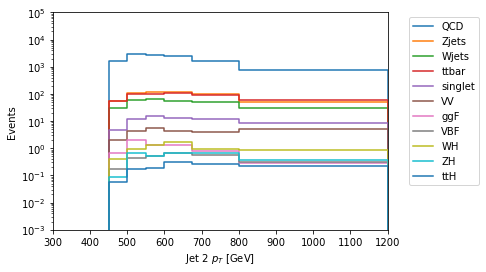

In [46]:
plot_overlay(x,'pt2')

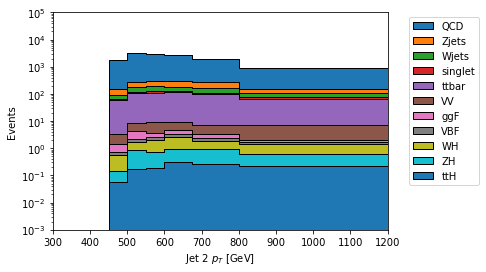

In [47]:
plot_stack(x,'pt2')

In [48]:
x = templates.sum('pt2', 'n2ddt2', 'msd1').integrate('ddb1',int_range=slice(0.89,1))

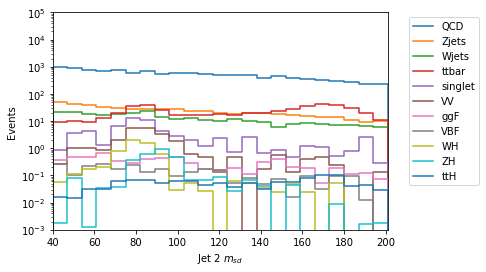

In [49]:
plot_overlay(x,'msd2')

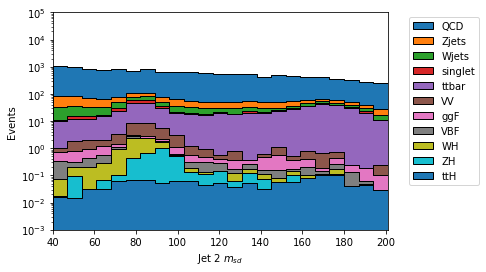

In [50]:
plot_stack(x,'msd2')

In [51]:
x = templates.sum('pt2','msd2','msd1').integrate('ddb1',int_range=slice(0.89,1))

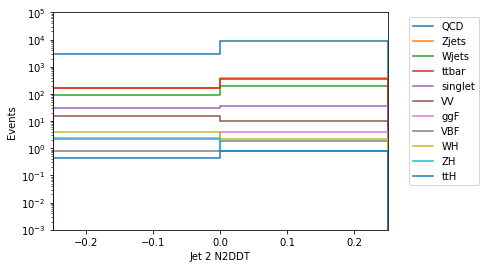

In [52]:
plot_overlay(x,'n2ddt2')

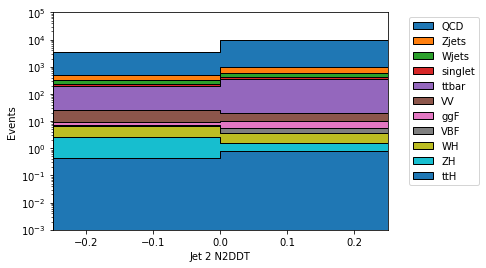

In [53]:
plot_stack(x,'n2ddt2')

In [54]:
x = templates.integrate('msd1',int_range=slice(mbb_min, mbb_max)).integrate('ddb1',int_range=slice(0.89,1))

0.21320273988905278
[75 96]


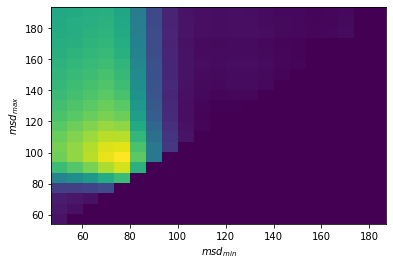

In [55]:
if year == '2017':

    cuts3 = []
    sigs3 = []

    msd2_slices = [i*7+40 for i in range(1,23)]
    for msd2_min in msd2_slices:
        for msd2_max in msd2_slices:
            if msd2_max <= msd2_min:
                continue

            sliced = x.sum('pt2','n2ddt2').integrate('msd2',int_range=slice(msd2_min,msd2_max))
            s = sliced.values()[('ZH',)] + sliced.values()[('WH',)]
            b = sliced.values()[('ggF',)] + sliced.values()[('VBF',)] + sliced.values()[('ttH',)] 
            b += sliced.values()[('QCD',)] + sliced.values()[('Wjets',)] + sliced.values()[('Zjets',)] + sliced.values()[('VV',)] + sliced.values()[('ttbar',)] + sliced.values()[('singlet',)]
            
            sigs3 += [significance(s,b)]
            cuts3 += [[msd2_min,msd2_max]]
        
    cuts3 = np.array(cuts3)
    print(max(sigs3))
    print(cuts3[np.argmax(sigs3)])

    msd_min_vh = cuts3[np.argmax(sigs3)][0]
    msd_max_vh = cuts3[np.argmax(sigs3)][1]

    plt.hist2d(cuts3[:,0], cuts3[:,1], density=False, weights=sigs3, bins=[21,21]);
    plt.xlabel('$msd_{min}$');
    plt.ylabel('$msd_{max}$');
    plt.savefig(year+'/plot-all/vh_2d_msdminmax.png')
    
else:
    msd2_min = 75
    msd2_max = 96

0.2956818179764682
[550.   0.]


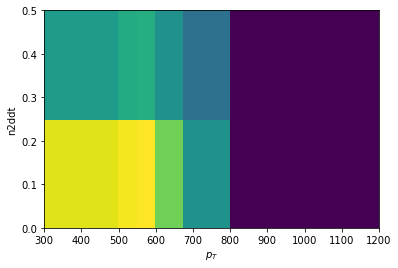

In [56]:
if year == '2017':

    cuts5 = []
    sigs5 = []

    pt2_slices = [300, 350, 400, 450, 500, 550, 600, 675, 800]
    n2ddt2_slices = [-0.25+0.25*i for i in range(1,3)]

    for pt2 in pt2_slices:
        for n2ddt2 in n2ddt2_slices:

            msd2_min = msd_min_vh
            msd2_max = msd_max_vh
        
            sliced = x.integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('pt2',int_range=slice(pt2,1200)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2))
        
            s = sliced.values()[('ZH',)] + sliced.values()[('WH',)]
            b = sliced.values()[('ggF',)] + sliced.values()[('VBF',)] + sliced.values()[('ttH',)] 
            b += sliced.values()[('QCD',)] + sliced.values()[('Wjets',)] + sliced.values()[('Zjets',)] + sliced.values()[('VV',)] + sliced.values()[('ttbar',)] + sliced.values()[('singlet',)]
            
            sigs5 += [significance(s,b)]
            cuts5 += [[pt2,n2ddt2]]
        
    cuts5 = np.array(cuts5)
    print(max(sigs5))
    print(cuts5[np.argmax(sigs5)])

    n2ddt2_cut = cuts5[np.argmax(sigs5)][1]
    pt2_cut = cuts5[np.argmax(sigs5)][0]

    plt.hist2d(cuts5[:,0], cuts5[:,1], density=False, weights=sigs5, bins=[[300, 350, 400, 450, 500, 550, 600, 675, 800, 1200],[0,0.25,0.5]]);
    plt.xlabel('$p_{T}$');
    plt.ylabel('n2ddt');
    plt.savefig(year+'/plot-all/vh_2d_n2ddtpt.png')
    
else:
    pt2_cut = 550
    n2ddt2_cut = 0

{'ttH': [0.05268369480112878], 'ZH': [0.7322531860992318], 'WH': [1.6336236124648411], 'VBF': [0.12123725853030388], 'ggF': [0.0719240001569492], 'VV': [0.0], 'ttbar': [13.267236723622965], 'singlet': [2.902757683321453], 'Wjets': [2.3760025329926266], 'Zjets': [1.2442819351485785], 'QCD': [43.20293506493685]}


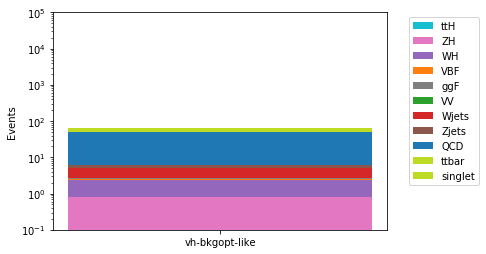

In [57]:
sr = x.integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2_cut)).integrate('pt2',int_range=slice(pt2_cut,1200)).values()
yield_plot(sr, 'vh-bkgopt')

In [58]:
# significance
s = sr[('WH',)] + sr[('ZH',)]
b = sr[('QCD',)] + sr[('Zjets',)] + sr[('Wjets',)]  + sr[('VV',)] + sr[('ttbar',)] +sr[('singlet',)] + sr[('ggF',)] + sr[('VBF',)] + sr[('ttH',)]

print(s,b)
print(significance(s,b))

# this only makes sense in the mass window of Higgs

2.3658767985640727 63.239058893510865
0.2956818179764682


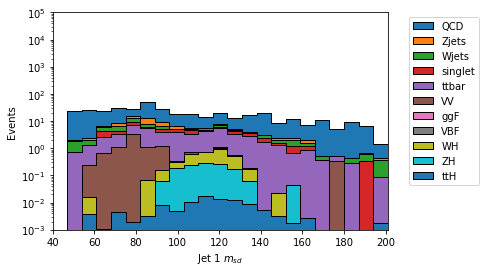

In [59]:
mhist = templates.integrate('ddb1',int_range=slice(0.89,1)).integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2_cut)).integrate('pt2',int_range=slice(pt2_cut,1200))
plot_stack(mhist,'vh-msd1')

In [60]:
# msd2 cut
templates.sum('msd1','pt2','n2ddt2','ddb1').integrate('msd2',int_range=slice(msd2_min,msd2_max)).values()

{('ZH',): 2.9618723088925267,
 ('WH',): 6.0922104526891925,
 ('ttH',): 0.6562668838296691,
 ('VBF',): 0.8053536514889534,
 ('ggF',): 1.6171718004333906,
 ('QCD',): 99601.44581612527,
 ('VV',): 182.81183170894437,
 ('Wjets',): 3233.3145366911253,
 ('Zjets',): 1348.6757996646224,
 ('ttbar',): 760.4131886112384,
 ('singlet',): 228.5186711293313}

In [61]:
# n2ddt2
templates.sum('msd1','pt2','ddb1').integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2_cut)).values()

{('ZH',): 2.270547438165524,
 ('WH',): 4.233766174515043,
 ('ttH',): 0.40214287355312683,
 ('VBF',): 0.2768448167147757,
 ('ggF',): 0.6362061211170469,
 ('QCD',): 25916.642772825682,
 ('VV',): 121.48782721772055,
 ('Wjets',): 1682.4674845205782,
 ('Zjets',): 603.6168169581272,
 ('ttbar',): 488.47433833098665,
 ('singlet',): 154.31028766613645}

In [62]:
# pt2
templates.sum('msd1','ddb1').integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2_cut)).integrate('pt2',int_range=slice(pt2_cut,1200)).values()

{('ZH',): 1.7977375368720545,
 ('WH',): 3.0422489054582753,
 ('ttH',): 0.2892868805970024,
 ('VBF',): 0.21955502773330435,
 ('ggF',): 0.14607170501536085,
 ('QCD',): 15641.83589806189,
 ('VV',): 84.06380577452511,
 ('Wjets',): 1085.8577284242742,
 ('Zjets',): 399.4311343891494,
 ('ttbar',): 311.60054760292496,
 ('singlet',): 110.74465675973697}

In [63]:
# ddb1
templates.sum('msd1').integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2_cut)).integrate('pt2',int_range=slice(pt2_cut,1200)).integrate('ddb1',int_range=slice(0.89,1)).values()

{('ZH',): 1.2394892799910644,
 ('WH',): 2.321870926324242,
 ('ttH',): 0.10464015472507099,
 ('VBF',): 0.13671710219680888,
 ('ggF',): 0.0719240001569492,
 ('QCD',): 289.5506222632943,
 ('VV',): 7.865243577503737,
 ('Wjets',): 18.818445254058133,
 ('Zjets',): 18.40924676622923,
 ('ttbar',): 42.36591387418126,
 ('singlet',): 13.349533406412235}

In [64]:
VH = 0
tot_H = 0

#2016
VH += 0.8091441474474412 + 1.5764221235600495
tot_H += 0.8091441474474412 + 1.5764221235600495 + 0.08625876074925605 + 0.11141318536880082 + 0.12412610951976455

#2017
VH += 1.2394892799910644 + 2.321870926324242
tot_H += 1.2394892799910644 + 2.321870926324242 + 0.10464015472507099 + 0.13671710219680888 + 0.0719240001569492

#2018
VH += 1.796843647093464 + 3.0266777352785104
tot_H += 1.796843647093464 + 3.0266777352785104 + 0.12791564415283477 + 0.15482107555629998 + 0.17421801755071475

print(VH/tot_H)

0.9079421947032702


In [65]:
np.sqrt(.206*.206 + .296*.296 + .335*.335)

0.4922164158172704